In [1]:
import os
import copy
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import shapely
import datetime
import math

import seaborn
from matplotlib import pyplot as plt
from itertools import chain
from functools import reduce
from collections import Counter

import statsmodels.api as sm
import statsmodels.gam.api as smgam
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
###  step 1)  recall all downloaded records

nb_stations = pd.read_excel(f"./src/NB_Air_Quality_stations_metadata.xlsx")

nb_records_path = f"/content/drive/MyDrive/TEMPO/Code Resources/Saint John/output/"
nb_so2_files = [x for x in os.listdir(nb_records_path) if "NB FEM SO2" in x]
nb_trs_files = [x for x in os.listdir(nb_records_path) if "NB FEM TRS" in x]


nb_so2_records = []
nb_so2_stations = []

for s in range(len(nb_so2_files)):
    nb_station_records = pd.read_excel(nb_records_path + nb_so2_files[s])
    nb_station_records = nb_station_records.iloc[0:-1,:]

    nb_map_stations = list(nb_station_records.columns)[1:]
    nb_map_stations = [x for x in nb_map_stations if x != "Colson Cove - Musquash"]
    nb_map_stations = [x.replace("–", "-").replace(" - IOL", "") for x in nb_map_stations]

    nb_stations_tem = nb_stations[(nb_stations['city'] + " - " + nb_stations['station_name']).isin(nb_map_stations) &
                                  (nb_stations['measurements'] == "SO2")]
    nb_stations_tem = nb_stations_tem[~((nb_stations_tem['station_name'] == "Forest Hills") & (nb_stations_tem['owner'] == "Government of New Brunswick"))]

    nb_stations_tem['geometry'] = list(zip(nb_stations_tem['longitude'], nb_stations_tem['latitude']))
    nb_stations_tem['geometry'] = nb_stations_tem['geometry'].apply(shapely.Point)
    nb_stations_tem = gpd.GeoDataFrame(nb_stations_tem, geometry='geometry', crs = 'epsg:4326')

    nb_so2_records.append(nb_station_records)
    nb_so2_stations.append(nb_stations_tem)

nb_so2_records = pd.concat(nb_so2_records)
nb_so2_stations = pd.concat(nb_so2_stations).drop_duplicates()
nb_so2_records = nb_so2_records.drop(["Colson Cove - Musquash"], axis=1)
nb_so2_records.columns = ["Result_Date"] + nb_map_stations


nb_TRS_records = pd.read_excel(nb_records_path + nb_trs_files[0])
nb_TRS_records = nb_TRS_records.iloc[0:-1,:]
nb_TRS_map_stations = list(nb_TRS_records.columns)[1:]
nb_TRS_map_stations = [x.replace("–", "-").replace(" - IOL", "") for x in nb_TRS_map_stations]

nb_TRS_stations = nb_stations[(nb_stations['city'] + " - " + nb_stations['station_name']).isin(nb_TRS_map_stations)]
nb_TRS_stations = nb_TRS_stations.drop(["measurements"], axis=1).drop_duplicates()
nb_TRS_stations = nb_TRS_stations[~((nb_TRS_stations['station_name'] == "Forest Hills") & (nb_TRS_stations['owner'] == "Government of New Brunswick"))]

nb_TRS_stations['geometry'] = list(zip(nb_TRS_stations['longitude'], nb_stations_tem['latitude']))
nb_TRS_stations['geometry'] = nb_TRS_stations['geometry'].apply(shapely.Point)
nb_TRS_stations = gpd.GeoDataFrame(nb_TRS_stations, geometry='geometry', crs = 'epsg:4326')

nb_TRS_records.columns = ["Result_Date"] + nb_TRS_map_stations

In [7]:
###  step 2)  create a time-series SO2 and TRS dataset

date_range = pd.date_range(start='2021-05-25 00:00:00', end='2024-01-01 23:00:00', freq='H')

ts_train_data_so2 = copy.deepcopy(nb_so2_records)
ts_train_data_trs = nb_TRS_records[[x for x in nb_TRS_records.columns if x in nb_so2_records.columns]]
ts_train_data_so2['pollutant'] = "SO2"
ts_train_data_trs['pollutant'] = "TRS"

ts_train_data = pd.concat([ts_train_data_so2, ts_train_data_trs])
ts_train_data = pd.melt(ts_train_data, id_vars=["Result_Date","pollutant"])
ts_train_data = pd.pivot(ts_train_data, index=["variable","Result_Date"], columns=["pollutant"])
ts_train_data = ts_train_data.reset_index()
ts_train_data.columns = ['station', 'date_hour'] + [c[1] for c in ts_train_data.columns][2:]
ts_train_data['station'] = ts_train_data['station'].apply(lambda x: x.replace("Saint John - ", ""))
ts_train_data['station'] = ts_train_data['station'].apply(lambda x: x.replace("Colson Cove - ", ""))

ts_train_data['year_month'] = ts_train_data['date_hour'].apply(lambda x: str(x.year) + "-" + str(x.month))
ts_train_data['year_week'] = ts_train_data['date_hour'].apply(lambda x: str(x.year) + "-" + str(x.week))
ts_train_data['day'] = ts_train_data['date_hour'].apply(lambda x: x.date())
ts_train_data['day_of_year'] = ts_train_data['day'].apply(lambda x: x.timetuple().tm_yday)
ts_train_data['month'] = ts_train_data['date_hour'].apply(lambda x: x.month)
ts_train_data['hour'] = ts_train_data['date_hour'].apply(lambda x: x.hour)
ts_train_data['week'] = ts_train_data['date_hour'].apply(lambda x: x.week)
ts_train_data['weekday'] = ts_train_data['date_hour'].apply(lambda x: x.weekday())

In [8]:
ts_train_data_local_daily_mean = ts_train_data.groupby(["station","day"]).agg({"SO2": np.nanmean, "TRS": np.nanmean})
ts_train_data_local_daily_mean = ts_train_data_local_daily_mean.reset_index()

ts_train_data_local_weekly_mean = ts_train_data.groupby(["station","year_week"]).agg({"SO2": np.nanmean, "TRS": np.nanmean})
ts_train_data_local_weekly_mean = ts_train_data_local_weekly_mean.reset_index()

ts_train_data_local_monthly_mean = ts_train_data.groupby(["station","year_month"]).agg({"SO2": np.nanmean, "TRS": np.nanmean})
ts_train_data_local_monthly_mean = ts_train_data_local_monthly_mean.reset_index()

ts_train_data['SO2'] = ts_train_data.apply(lambda x: ts_train_data_local_daily_mean[((ts_train_data_local_daily_mean['station'] == x['station']) &
                                                                                     (ts_train_data_local_daily_mean['day'] == x['day']))]['SO2'].values[0]
                                                       if pd.isnull(x['SO2']) else x['SO2'],
                                                       axis = 1)
ts_train_data['TRS'] = ts_train_data.apply(lambda x: ts_train_data_local_daily_mean[((ts_train_data_local_daily_mean['station'] == x['station']) &
                                                                                     (ts_train_data_local_daily_mean['day'] == x['day']))]['TRS'].values[0]
                                                       if pd.isnull(x['TRS']) else x['TRS'],
                                                       axis = 1)

ts_train_data['SO2'] = ts_train_data.apply(lambda x: ts_train_data_local_weekly_mean[((ts_train_data_local_weekly_mean['station'] == x['station']) &
                                                                                      (ts_train_data_local_weekly_mean['year_week'] == x['year_week']))]['SO2'].values[0]
                                                       if pd.isnull(x['SO2']) else x['SO2'],
                                                       axis = 1)
ts_train_data['TRS'] = ts_train_data.apply(lambda x: ts_train_data_local_weekly_mean[((ts_train_data_local_weekly_mean['station'] == x['station']) &
                                                                                      (ts_train_data_local_weekly_mean['year_week'] == x['year_week']))]['TRS'].values[0]
                                                       if pd.isnull(x['TRS']) else x['TRS'],
                                                       axis = 1)

ts_train_data['SO2'] = ts_train_data.apply(lambda x: ts_train_data_local_monthly_mean[((ts_train_data_local_monthly_mean['station'] == x['station']) &
                                                                                       (ts_train_data_local_monthly_mean['year_month'] == x['year_month']))]['SO2'].values[0]
                                                       if pd.isnull(x['SO2']) else x['SO2'],
                                                       axis = 1)
ts_train_data['TRS'] = ts_train_data.apply(lambda x: ts_train_data_local_monthly_mean[((ts_train_data_local_monthly_mean['station'] == x['station']) &
                                                                                       (ts_train_data_local_monthly_mean['year_month'] == x['year_month']))]['TRS'].values[0]
                                                       if pd.isnull(x['TRS']) else x['TRS'],
                                                       axis = 1)

In [9]:
ts_train_data_expand = copy.deepcopy(ts_train_data)

for lag in range(36):
    ts_train_data_expand["TRS_1hr_lag_" + str(lag+1)] = ts_train_data_expand.groupby(["station"])["TRS"].shift(lag)

ts_train_data_expand['TRS_4hr_lag_mean'] = ts_train_data_expand[["TRS_1hr_lag_" + str(x) for x in range(1, 5)]].mean(axis=1)
ts_train_data_expand['TRS_4hr_lag_max'] = ts_train_data_expand[["TRS_1hr_lag_" + str(x) for x in range(1, 5)]].max(axis=1)
ts_train_data_expand['TRS_8hr_lag_mean'] = ts_train_data_expand[["TRS_1hr_lag_" + str(x) for x in range(1, 9)]].mean(axis=1)
ts_train_data_expand['TRS_8hr_lag_max'] = ts_train_data_expand[["TRS_1hr_lag_" + str(x) for x in range(1, 9)]].max(axis=1)
ts_train_data_expand['TRS_12hr_lag_mean'] = ts_train_data_expand[["TRS_1hr_lag_" + str(x) for x in range(1, 13)]].mean(axis=1)
ts_train_data_expand['TRS_12hr_lag_max'] = ts_train_data_expand[["TRS_1hr_lag_" + str(x) for x in range(1, 13)]].max(axis=1)
ts_train_data_expand['TRS_24hr_lag_mean'] = ts_train_data_expand[["TRS_1hr_lag_" + str(x) for x in range(1, 25)]].mean(axis=1)
ts_train_data_expand['TRS_24hr_lag_max'] = ts_train_data_expand[["TRS_1hr_lag_" + str(x) for x in range(1, 25)]].max(axis=1)

In [10]:
train_stations = [x.replace("Saint John - ", "") for x in nb_so2_records.columns if x in nb_TRS_records.columns and x != "Result_Date"]
train_stations = nb_stations[nb_stations['station_name'].isin(train_stations)][['station_name','latitude','longitude']].drop_duplicates()
train_stations = train_stations.iloc[1:,:]

all_stations = nb_stations[nb_stations['station_name'].isin(ts_train_data_expand['station'])][['station_name','latitude','longitude']].drop_duplicates()
all_stations = all_stations.iloc[1:,:]

In [11]:
def dist(x, y):
    lat1 = math.radians(x[0])
    lon1 = math.radians(x[1])
    lat2 = math.radians(y[0])
    lon2 = math.radians(y[1])
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return round(distance, 4)

In [12]:
points = all_stations['station_name']
distances = scipy.spatial.distance.pdist(all_stations[['latitude','longitude']].values, metric=dist)
station_distances = pd.DataFrame(scipy.spatial.distance.squareform(distances), columns=points, index=points)

In [13]:
weighted_so2 = []

for s in train_stations['station_name']:
    station_ts = ts_train_data_expand[ts_train_data_expand['station'] == s]
    station_inclusion = station_distances.loc[s, :][station_distances.loc[s, :] < 4].index.tolist()
    station_weightings = station_distances.loc[s, [x for x in station_distances.columns if x != s and x in station_inclusion]]
    station_weightings = 1 / (station_weightings / station_weightings.sum())
    station_weightings = station_weightings / station_weightings.sum()
    nearby_counter = 1
    for w in [x for x in station_inclusion if x != s]:
        station_ts_w = ts_train_data_expand[ts_train_data_expand['station'] == w][['date_hour','SO2']]
        station_ts_w['SO2'] = station_ts_w['SO2'] * station_weightings.loc[w]
        station_ts_w.columns = ['date_hour','nearby_station_' + str(nearby_counter) + "_SO2"]
        station_ts = station_ts.merge(station_ts_w, on=['date_hour'], how="left")
        nearby_counter += 1
    lng = len([x for x in station_inclusion if x != s])
    station_ts['weighted_SO2'] = station_ts.iloc[:, (station_ts.shape[1]-lng):station_ts.shape[1]].mean(axis=1)
    weighted_so2.append(station_ts)

weighted_so2 = pd.concat(weighted_so2)
weighted_so2 = weighted_so2[['station','date_hour','weighted_SO2']]

In [14]:
ts_train_data_expand = ts_train_data_expand[ts_train_data_expand['station'].isin(train_stations['station_name'])]
ts_train_data_expand = ts_train_data_expand.merge(weighted_so2, on=['station','date_hour'], how='left')

for lag in range(36):
    ts_train_data_expand["weighted_SO2_1hr_lag_" + str(lag+1)] = ts_train_data_expand.groupby(["station"])["weighted_SO2"].shift(lag)

ts_train_data_expand['weighted_SO2_4hr_lag_mean'] = ts_train_data_expand[["weighted_SO2_1hr_lag_" + str(x) for x in range(1, 5)]].mean(axis=1)
ts_train_data_expand['weighted_SO2_4hr_lag_max'] = ts_train_data_expand[["weighted_SO2_1hr_lag_" + str(x) for x in range(1, 5)]].max(axis=1)
ts_train_data_expand['weighted_SO2_8hr_lag_mean'] = ts_train_data_expand[["weighted_SO2_1hr_lag_" + str(x) for x in range(1, 9)]].mean(axis=1)
ts_train_data_expand['weighted_SO2_8hr_lag_max'] = ts_train_data_expand[["weighted_SO2_1hr_lag_" + str(x) for x in range(1, 9)]].max(axis=1)
ts_train_data_expand['weighted_SO2_12hr_lag_mean'] = ts_train_data_expand[["weighted_SO2_1hr_lag_" + str(x) for x in range(1, 13)]].mean(axis=1)
ts_train_data_expand['weighted_SO2_12hr_lag_max'] = ts_train_data_expand[["weighted_SO2_1hr_lag_" + str(x) for x in range(1, 13)]].max(axis=1)
ts_train_data_expand['weighted_SO2_24hr_lag_mean'] = ts_train_data_expand[["weighted_SO2_1hr_lag_" + str(x) for x in range(1, 25)]].mean(axis=1)
ts_train_data_expand['weighted_SO2_24hr_lag_max'] = ts_train_data_expand[["weighted_SO2_1hr_lag_" + str(x) for x in range(1, 25)]].max(axis=1)

In [15]:
seasonality_dict = {}
trend_dict = {}
resid_dict = {}

for n in ts_train_data_expand['station'].drop_duplicates():
    decompose = seasonal_decompose(ts_train_data_expand[ts_train_data_expand['station'] == n].set_index('date_hour')['TRS'], 
                                   model="additive", period=24, extrapolate_trend=True)
    seasonality_dict[n] = decompose.seasonal
    trend_dict[n] = decompose.trend
    resid_dict[n] = decompose.resid

additive_seasonality_trs = pd.melt(pd.DataFrame(seasonality_dict).reset_index(), id_vars="date_hour")
additive_trend_trs = pd.melt(pd.DataFrame(trend_dict).reset_index(), id_vars="date_hour")
additive_resid_trs = pd.melt(pd.DataFrame(resid_dict).reset_index(), id_vars="date_hour")

seasonality_dict = {}
trend_dict = {}
resid_dict = {}

for n in ts_train_data_expand['station'].drop_duplicates():
    decompose = seasonal_decompose(ts_train_data_expand[ts_train_data_expand['station'] == n].set_index('date_hour')['TRS'] + 0.0001, 
                                   model="multiplicative", period=24, extrapolate_trend=True)
    seasonality_dict[n] = decompose.seasonal
    trend_dict[n] = decompose.trend
    resid_dict[n] = decompose.resid

multiplicative_seasonality_trs = pd.melt(pd.DataFrame(seasonality_dict).reset_index(), id_vars="date_hour")
multiplicative_trend_trs = pd.melt(pd.DataFrame(trend_dict).reset_index(), id_vars="date_hour")
multiplicative_resid_trs = pd.melt(pd.DataFrame(resid_dict).reset_index(), id_vars="date_hour")

seasonality_dict = {}
trend_dict = {}
resid_dict = {}

for n in ts_train_data_expand['station'].drop_duplicates():
    decompose = seasonal_decompose(ts_train_data_expand[ts_train_data_expand['station'] == n].set_index('date_hour')['weighted_SO2'], 
                                   model="additive", period=24, extrapolate_trend=True)
    seasonality_dict[n] = decompose.seasonal
    trend_dict[n] = decompose.trend
    resid_dict[n] = decompose.resid

additive_seasonality_so2 = pd.melt(pd.DataFrame(seasonality_dict).reset_index(), id_vars="date_hour")
additive_trend_so2 = pd.melt(pd.DataFrame(trend_dict).reset_index(), id_vars="date_hour")
additive_resid_so2 = pd.melt(pd.DataFrame(resid_dict).reset_index(), id_vars="date_hour")

seasonality_dict = {}
trend_dict = {}
resid_dict = {}

for n in ts_train_data_expand['station'].drop_duplicates():
    decompose = seasonal_decompose(ts_train_data_expand[ts_train_data_expand['station'] == n].set_index('date_hour')['weighted_SO2'] + 0.0001, 
                                   model="multiplicative", period=24, extrapolate_trend=True)
    seasonality_dict[n] = decompose.seasonal
    trend_dict[n] = decompose.trend
    resid_dict[n] = decompose.resid

multiplicative_seasonality_so2 = pd.melt(pd.DataFrame(seasonality_dict).reset_index(), id_vars="date_hour")
multiplicative_trend_so2 = pd.melt(pd.DataFrame(trend_dict).reset_index(), id_vars="date_hour")
multiplicative_resid_so2 = pd.melt(pd.DataFrame(resid_dict).reset_index(), id_vars="date_hour")

additive_seasonality_trs.columns = ['date_hour','station','additive_seasonality_TRS']
additive_trend_trs.columns = ['date_hour','station','additive_trend_TRS']
additive_resid_trs.columns = ['date_hour','station','additive_resid_TRS']
multiplicative_seasonality_trs.columns = ['date_hour','station','multiplicative_seasonality_TRS']
multiplicative_trend_trs.columns = ['date_hour','station','multiplicative_trend_TRS']
multiplicative_resid_trs.columns = ['date_hour','station','multiplicative_resid_TRS']

additive_seasonality_so2.columns = ['date_hour','station','additive_seasonality_weighted_SO2']
additive_trend_so2.columns = ['date_hour','station','additive_trend_weighted_SO2']
additive_resid_so2.columns = ['date_hour','station','additive_resid_weighted_SO2']
multiplicative_seasonality_so2.columns = ['date_hour','station','multiplicative_seasonality_weighted_SO2']
multiplicative_trend_so2.columns = ['date_hour','station','multiplicative_trend_weighted_SO2']
multiplicative_resid_so2.columns = ['date_hour','station','multiplicative_resid_weighted_SO2']

In [16]:
ts_train_data_expand = reduce(lambda df1, df2: pd.merge(df1, df2, on=['date_hour','station'], how="left"),
                              [ts_train_data_expand,
                               additive_seasonality_trs, additive_trend_trs, additive_resid_trs,
                               multiplicative_seasonality_trs, multiplicative_trend_trs, multiplicative_resid_trs,
                               additive_seasonality_so2, additive_trend_so2, additive_resid_so2,
                               multiplicative_seasonality_so2, multiplicative_trend_so2, multiplicative_resid_so2
                               ])

ts_train_data_expand = ts_train_data_expand.dropna()

ts_train_data_expand['SO2_above_0'] = ts_train_data_expand['SO2'].apply(lambda x: 0 if x == 0 else 1)

In [4]:
ts_train_data_expand = ts_train_data_expand[ts_train_data_expand['day'].apply(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d")) >= '2022-01-01']

In [5]:
with open(f"./archive/gbm_augment_classification.pkl", "rb") as f:
    gbmcfull = pickle.load(f)

with open(f"./archive/gbm_augment_log_transform.pkl", "rb") as f:
    gbmlogfull = pickle.load(f)

In [6]:
endog = ts_train_data_expand['SO2_above_0']
exog = np.log(ts_train_data_expand[
    [x for x in ts_train_data_expand.columns 
       if "TRS" in x or "weighted_SO2" in x]
] + 0.0001)
exog = np.concatenate((
        np.log(ts_train_data_expand[[x for x in ts_train_data_expand.columns 
                                     if x == "TRS" or 
                                        ("TRS" in x and 
                                         "1hr" in x)]] + 0.0001),
        np.log(ts_train_data_expand[[x for x in ts_train_data_expand.columns 
                                     if x == "weighted_SO2" or 
                                        ("weighted_SO2" in x and 
                                         "1hr" in x)]] + 0.0001),
        np.log(ts_train_data_expand[[x for x in ts_train_data_expand.columns 
                                     if "TRS_" in x and 
                                        "1hr" not in x and 
                                        "additive" not in x and 
                                        "multiplicative" not in x and 
                                        "diff" not in x]] + 0.0001),
        np.log(ts_train_data_expand[[x for x in ts_train_data_expand.columns 
                                     if "weighted_SO2_" in x and 
                                        "1hr" not in x and 
                                        "additive" not in x and 
                                        "multiplicative" not in x]] + 0.0001),
        np.array(ts_train_data_expand[[x for x in ts_train_data_expand.columns 
                                       if "TRS" in x and 
                                          ("additive" in x or 
                                           "multiplicative" in x)]]),
        np.array(ts_train_data_expand[[x for x in ts_train_data_expand.columns 
                                       if "weighted_SO2" in x and 
                                          ("additive" in x or 
                                           "multiplicative" in x)]]),
        np.array(ts_train_data_expand[['month','week','weekday','day_of_year','hour']])
    ), axis = 1)

group = ts_train_data_expand['station'].astype(str) + " - " + ts_train_data_expand['SO2_above_0'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(exog, endog, test_size=0.2, random_state=42, stratify=group)

In [ ]:
gbmcfull = HistGradientBoostingClassifier(
    max_iter=50000, 
    learning_rate=0.001, 
    max_depth=10, 
    random_state=42,
    class_weight={
        0: 1 / (Counter(ts_train_data_expand['SO2_above_0'])[0] / (Counter(ts_train_data_expand['SO2_above_0'])[1] + Counter(ts_train_data_expand['SO2_above_0'])[0])),
        1: 1 / (Counter(ts_train_data_expand['SO2_above_0'])[1] / (Counter(ts_train_data_expand['SO2_above_0'])[1] + Counter(ts_train_data_expand['SO2_above_0'])[0]))
    }
)
gbmcfull.fit(X_train, y_train)

In [7]:
gbmcfull_preds_train = gbmcfull.predict(X_train)
gbmcfull_preds_test = gbmcfull.predict(X_test)

In [8]:
print(classification_report(y_train, gbmcfull_preds_train))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     22955
           1       0.96      0.92      0.94     33262

    accuracy                           0.93     56217
   macro avg       0.92      0.93      0.92     56217
weighted avg       0.93      0.93      0.93     56217



In [9]:
confusion_matrix(y_train, gbmcfull_preds_train)

array([[21539,  1416],
       [ 2702, 30560]])

In [10]:
print(classification_report(y_test, gbmcfull_preds_test))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      5739
           1       0.88      0.84      0.86      8316

    accuracy                           0.84     14055
   macro avg       0.84      0.84      0.84     14055
weighted avg       0.84      0.84      0.84     14055



In [11]:
confusion_matrix(y_test, gbmcfull_preds_test)

array([[4820,  919],
       [1300, 7016]])

In [12]:
select_data = ts_train_data_expand[ts_train_data_expand['SO2_above_0'] == 1]

endog = np.log(select_data['SO2'] + 0.001)
exog = np.log(select_data[
    [x for x in ts_train_data_expand.columns 
     if "TRS" in x or "weighted_SO2" in x]
] + 0.0001)
exog = np.concatenate((
        np.log(select_data[[x for x in ts_train_data_expand.columns 
                              if x == "TRS" or 
                                 ("TRS" in x and 
                                  "1hr" in x)]] + 0.0001),
        np.log(select_data[[x for x in ts_train_data_expand.columns 
                              if x == "weighted_SO2" or 
                                 ("weighted_SO2" in x and 
                                  "1hr" in x)]] + 0.0001),
        np.log(select_data[[x for x in ts_train_data_expand.columns 
                              if "TRS_" in x and 
                                 "1hr" not in x and 
                                 "additive" not in x and 
                                 "multiplicative" not in x]] + 0.0001),
        np.log(select_data[[x for x in ts_train_data_expand.columns 
                              if "weighted_SO2_" in x and 
                                 "1hr" not in x and 
                                 "additive" not in x and 
                                 "multiplicative" not in x]] + 0.0001),
        np.array(select_data[[x for x in ts_train_data_expand.columns 
                                if "TRS" in x and 
                                   ("additive" in x or 
                                    "multiplicative" in x)]]),
        np.array(select_data[[x for x in ts_train_data_expand.columns 
                                if "weighted_SO2" in x and 
                                   ("additive" in x or 
                                    "multiplicative" in x)]]),
        np.array(select_data[['month','week','weekday','day_of_year','hour']])
    ), axis = 1)

group = ts_train_data_expand[ts_train_data_expand['SO2_above_0'] == 1]['station']

X_train, X_test, y_train, y_test = train_test_split(exog, endog, test_size=0.2, random_state=42, stratify=group)

In [ ]:
gbmlogfull = HistGradientBoostingRegressor(max_iter=30000, learning_rate=0.001, max_depth=10, random_state=42)
gbmlogfull.fit(X_train, y_train)

In [13]:
gbmlogfull_preds_train = gbmlogfull.predict(X_train)
gbmlogfull_preds_test = gbmlogfull.predict(X_test)

In [18]:
print("R2: " + str(r2_score(y_train, gbmlogfull_preds_train)))
print("Pearson's r: " + str(scipy.stats.pearsonr(np.array(y_train).flatten(), gbmlogfull_preds_train)[0]))
print("MSE (log-scaled): " + str(mean_squared_error(y_train, gbmlogfull_preds_train)))
print("MAE (log-scaled): " + str(mean_absolute_error(y_train, gbmlogfull_preds_train)))
print("MAE (original scale): " + str(mean_absolute_error(np.exp(y_train) - 0.001, np.exp(gbmlogfull_preds_train) - 0.001)))
print("MedAE (original scale): " + str(median_absolute_error(np.exp(y_train) - 0.001, np.exp(gbmlogfull_preds_train) - 0.001)))
print("75-th Percentile AE (original scale): " + str(np.quantile(abs(np.exp(y_train) - np.exp(gbmlogfull_preds_train)), 0.75)))

R2: 0.745165196391065
Pearson's r: 0.8764408720668359
MSE (log-scaled): 0.48315187389639447
MAE (log-scaled): 0.5202929266547476
MAE (original scale): 0.9506365373444626
MedAE (original scale): 0.13154395510214326
75-th Percentile AE (original scale): 0.38460449869842717


In [19]:
print("R2: " + str(r2_score(y_test, gbmlogfull_preds_test)))
print("Pearson's r: " + str(scipy.stats.pearsonr(np.array(y_test).flatten(), gbmlogfull_preds_test)[0]))
print("MSE (log-scaled): " + str(mean_squared_error(y_test, gbmlogfull_preds_test)))
print("MAE (log-scaled): " + str(mean_absolute_error(y_test, gbmlogfull_preds_test)))
print("MAE (original scale): " + str(mean_absolute_error(np.exp(y_test) - 0.001, np.exp(gbmlogfull_preds_test) - 0.001)))
print("MedAE (original scale): " + str(median_absolute_error(np.exp(y_test) - 0.001, np.exp(gbmlogfull_preds_test) - 0.001)))
print("75-th Percentile AE (original scale): " + str(np.quantile(abs(np.exp(y_test) - np.exp(gbmlogfull_preds_test)), 0.75)))

R2: 0.5868994388063639
Pearson's r: 0.7729417314736124
MSE (log-scaled): 0.7795302001942177
MAE (log-scaled): 0.6577171094072002
MAE (original scale): 1.1525044133135467
MedAE (original scale): 0.16675862050546014
75-th Percentile AE (original scale): 0.5289285765604792


Text(0.5, 1.0, 'Testing Dataset (blue = actual, red = predictions)')

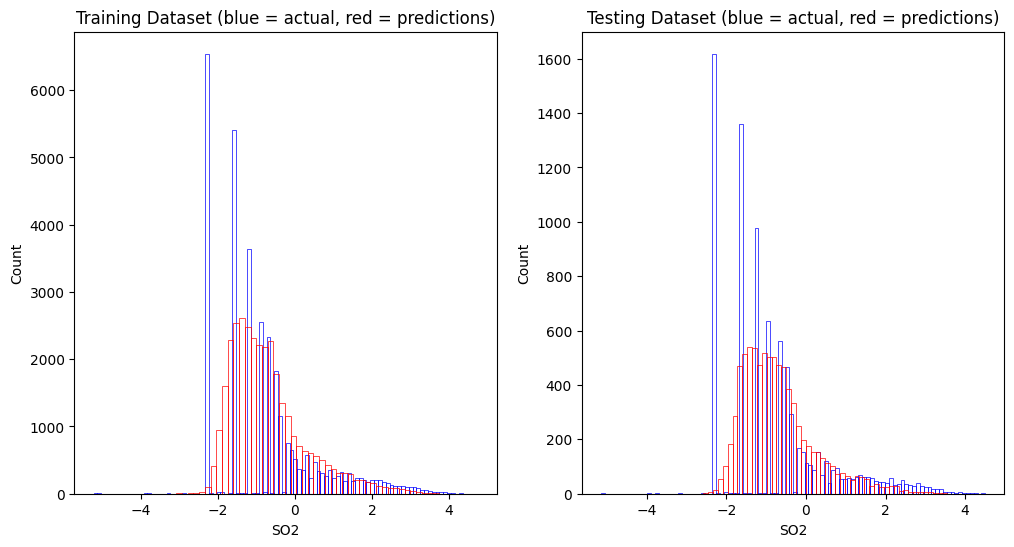

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
seaborn.histplot(y_train, ax=ax[0], color="blue", fill=False, bins=100)
seaborn.histplot(gbmlogfull_preds_train.reshape(-1), ax=ax[0], color="red", fill=False, bins=50)
ax[0].set_title("Training Dataset (blue = actual, red = predictions)")
seaborn.histplot(y_test, ax=ax[1], color="blue", fill=False, bins=100)
seaborn.histplot(gbmlogfull_preds_test.reshape(-1), ax=ax[1], color="red", fill=False, bins=50)
ax[1].set_title("Testing Dataset (blue = actual, red = predictions)")